# 03a - BigQuery Machine Learning (BQML) - Machine Learning with SQL
BigQuery has a number of machine learning algorithms callable directly from SQL. This gives the convenience of using the common language of SQL to "CREATE MODEL …). The library of available models is constantly growing and covers supervised, unsupervised, and time series methods as well as functions for evaluation - even anomaly detection from results, explainability and hyperparameter tuning. 
In this demonstration, BigQuery ML (BQML) is used to create a logistic regression model.

### Prerequisites:
- 01 - BigQuery - Table Data Source
### Overview:
- Train logistic regression model with BQML
    - CREATE MODEL …. model_type="LOGISTIC_REG"
- Review training information
    - SELECT * FROM ML.TRAINING_INFO…
- Evaluated the models performance
    - SELECT * FROM ML.EVALUATE…
- Review the classification errors with a confusion matrix
    - SELECT * FROM ML.CONFUSION_MATRIX…
- Create prediction for data in BigQuery
    - SELECT * FROM ML.PREDICT

---
## Setup

inputs:

In [2]:
REGION = 'us-central1'
PROJECT_ID='nguyen_demo5'
DATANAME = 'taxi'
NOTEBOOK = '03a'

# Model Training
VAR_TARGET = 'tips_label'
VAR_OMIT = ' unique_key taxi_id trip_start_timestamp trip_end_timestamp trip_seconds trip_miles pickup_census_tract dropoff_census_tract pickup_community_area dropoff_community_area fare tips tolls extras trip_total payment_type company pickup_latitude pickup_longitude pickup_location dropoff_latitude dropoff_longitude dropoff_location ' # add more variables to the string with space delimiters

packages:

In [3]:
from google.cloud import bigquery

clients:

In [4]:
bigquery = bigquery.Client()

---
## Train Model
Use BigQuery ML to train multiclass logistic regression model:
- This uses the splits column that notebook 01 created
-data_split_method = CUSTOM uses the column in data_split_col to assign training data for FALSE - values and evaluation data for TRUE values.

### Training the binary logistic regression model VERSION 1: taxi_lr_v1
- Using only `trips_seconds` variable
- `VAR_OMIT_V1`: contain all of the variables except variable `trips_seconds' 

In [6]:
VAR_OMIT_V1= 'unique_key taxi_id trip_start_timestamp trip_end_timestamp trip_miles pickup_census_tract dropoff_census_tract pickup_community_area dropoff_community_area fare tips tolls extras trip_total payment_type company pickup_latitude pickup_longitude pickup_location dropoff_latitude dropoff_longitude dropoff_location'

In [7]:
query = f"""
CREATE OR REPLACE MODEL `{DATANAME}.{DATANAME}_lr_v1`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT_V1.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{DATANAME}.{DATANAME}_prepped`
WHERE splits != 'TEST'
"""
job = bigquery.query(query = query)
job.result()

In [ ]:
(job.ended-job.started).total_seconds()

- Trained model V1: <br>
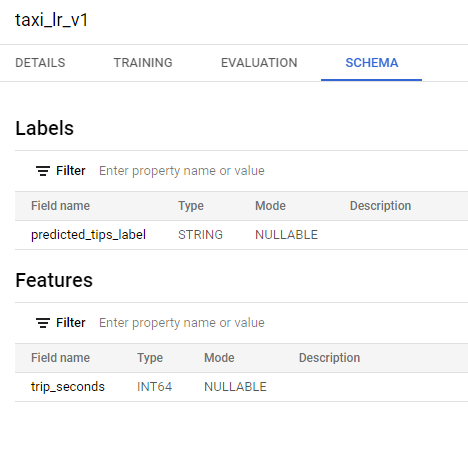

#### Evaluation:
- At the end of the training, we can access the ML model from the BigQuery
navigation menu to have a look at the performance of the model. Selecting the
Evaluation tab, we can see the **ROC AUC** value. 
- In this case, we can see we haven't achieved great results because it is not close to 1; it's **0.5598**
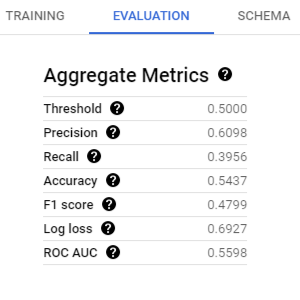

- In the same tab, we can also see the ROC curve:

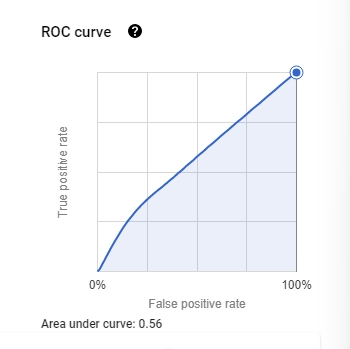
- As we can see from the preceding diagram, the ROC curve, which expresses the
rate between the true positive and the false positive, is not close to 1. The blue area
under the curve is about 50% of the entire square.
- As shown in the following screenshot, we can also leverage the confusion matrix
in the same tab to experiment with the outcome of the ML model according to
different thresholds:
| Score threshold | Confusion matrix |
| --- | ----------- |
| 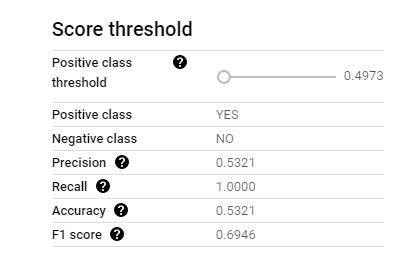 | 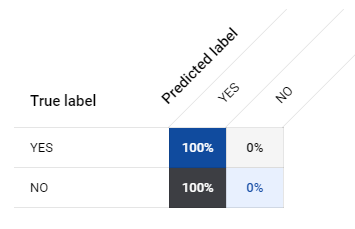 |

### Training the binary logistic regression model VERSION 2: taxi_lr_v2
- Using only `trips_seconds fare tolls company` variables
- `VAR_OMIT_V2`: contain all of the variables except variables `trips_seconds fare tolls company' 

In [9]:
VAR_OMIT_V2= 'unique_key taxi_id trip_start_timestamp trip_end_timestamp trip_miles pickup_census_tract dropoff_census_tract pickup_community_area dropoff_community_area tips extras trip_total payment_type pickup_latitude pickup_longitude pickup_location dropoff_latitude dropoff_longitude dropoff_location'

In [10]:
query = f"""
CREATE OR REPLACE MODEL `{DATANAME}.{DATANAME}_lr_v2`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT_V2.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{DATANAME}.{DATANAME}_prepped`
WHERE splits != 'TEST'
"""
job = bigquery.query(query = query)
job.result()

- Trained model v2: <br>
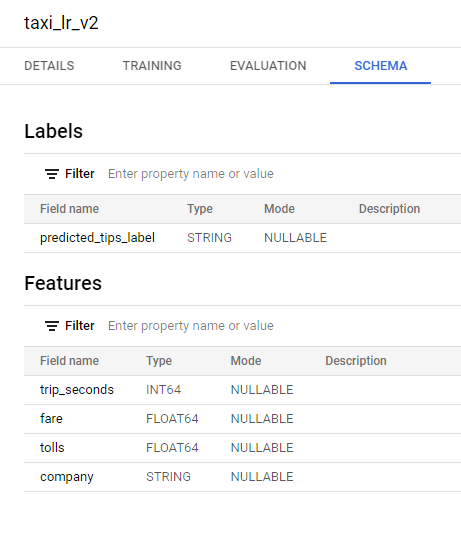

#### Evaluation:
The CREATE OR REPLACE MODEL part is similar to the previous one but
includes the new features previously mentioned. Despite adding the new fields, the
improvement in terms of **ROC AUC** is not significant. In fact, with this attempt, we
have achieved a value of **0.6034**.
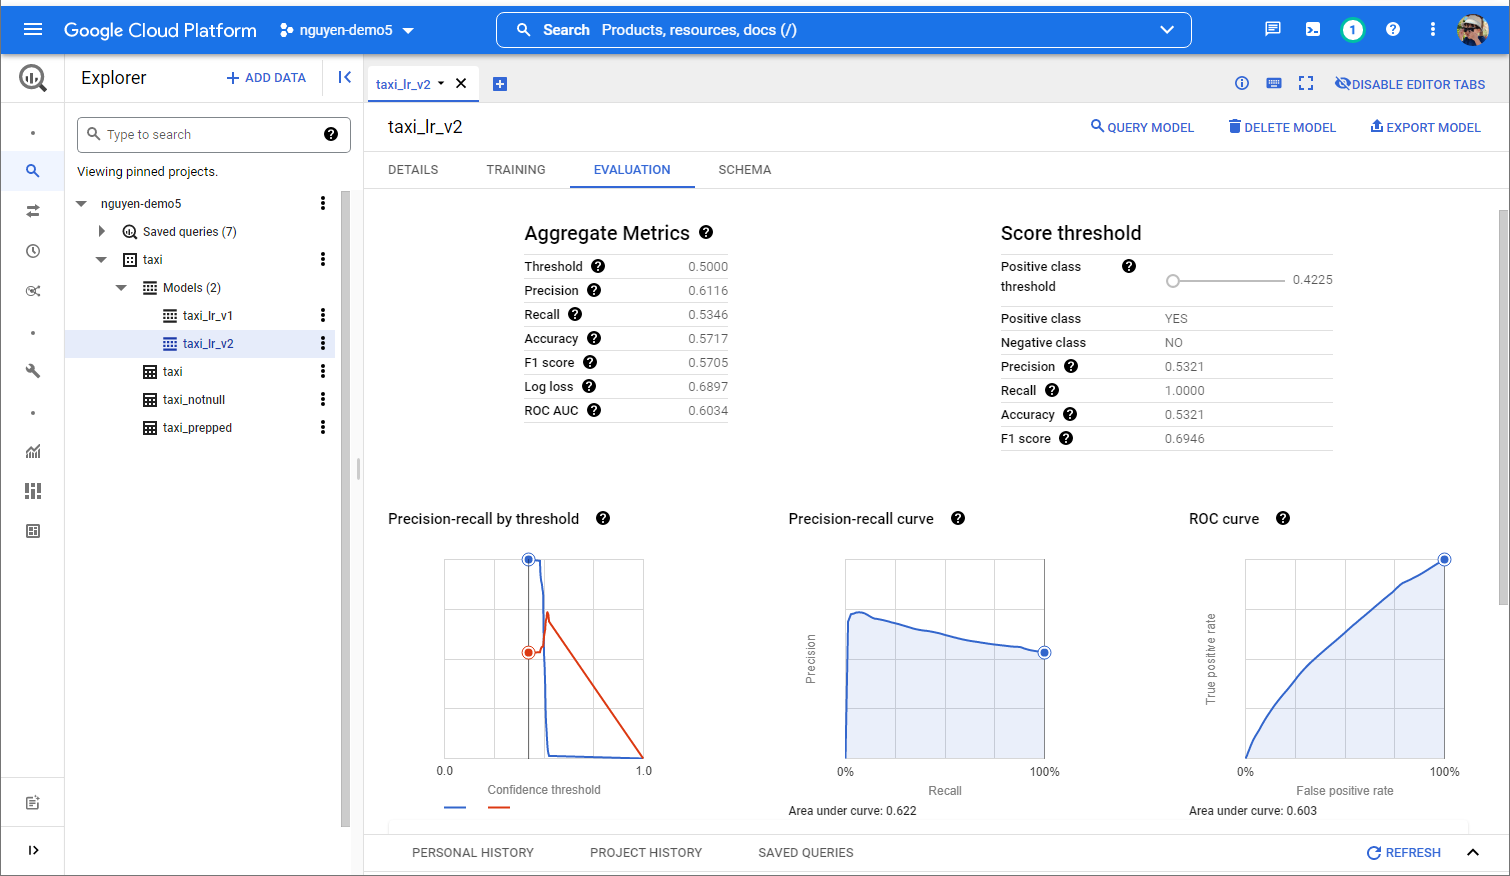

### Training the binary logistic regression model VERSION 3: taxi_lr_v3
- Using only `trips_seconds fare tolls company payment_type` variables
- `VAR_OMIT_V3`: contain all of the variables except variables `trips_seconds fare tolls company payment_type' 

In [12]:
VAR_OMIT_V3= 'unique_key taxi_id trip_start_timestamp trip_end_timestamp trip_miles pickup_census_tract dropoff_census_tract pickup_community_area dropoff_community_area tips extras trip_total pickup_latitude pickup_longitude pickup_location dropoff_latitude dropoff_longitude dropoff_location'

- It's time to introduce a feature that can be extremely helpful for the development of
our ML model. 
- The next ML model, binary_classification_version_3, will introduce the payment type used by the customer to pay the taxi driver:

In [13]:
query = f"""
CREATE OR REPLACE MODEL `{DATANAME}.{DATANAME}_lr_v3`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT_V3.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{DATANAME}.{DATANAME}_prepped`
WHERE splits != 'TEST'
"""
job = bigquery.query(query = query)
job.result()

-Trained model v3: <br>
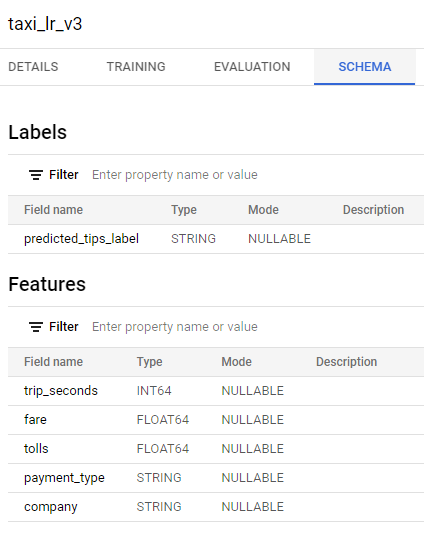

#### Evaluation:
- After the training of this ML model, we can immediately notice a huge increase in the value of **ROC AUC**. 
- Adding the payment method as a feature to our model, we have achieved a value of **0.9815**. 
- This is very close to 1 and represents a significant improvement in the performance of our binary logistic regression model. <br>
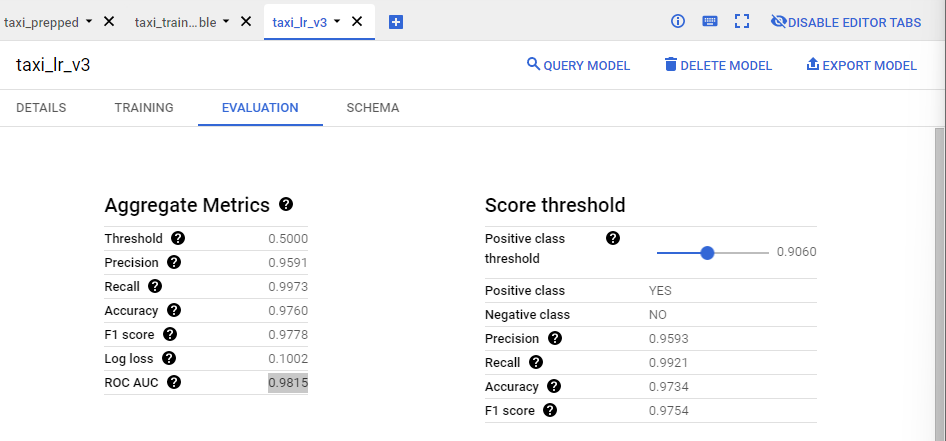


### Training the binary logistic regression model VERSION 4: taxi_lr_v4
- Using only `trips_seconds` `fare tolls` `company` `payment_type` `pickup_location` `dropoff_location` variables
- `VAR_OMIT_V3`: contain all of the variables except variables `trips_seconds` `fare tolls` `company` `payment_type` `pickup_location` `dropoff_location`

In [31]:
VAR_OMIT_V4= 'unique_key taxi_id trip_start_timestamp trip_end_timestamp trip_miles pickup_census_tract dropoff_census_tract pickup_community_area dropoff_community_area tips extras trip_total pickup_latitude pickup_longitude dropoff_latitude dropoff_longitude'

- The result that we've achieved with the version 3 ML model in the preceding code block is already a great result. 
- Let's see whether it's possible to further improve our classification model by leveraging the information about the pick-up and drop-off locations of the taxi trip:

In [32]:
query = f"""
CREATE OR REPLACE MODEL `{DATANAME}.{DATANAME}_lr_v4`
OPTIONS
    (model_type = 'LOGISTIC_REG',
        auto_class_weights = TRUE,
        input_label_cols = ['{VAR_TARGET}'],
        data_split_col = 'custom_splits',
        data_split_method = 'CUSTOM'
    ) AS
SELECT * EXCEPT({','.join(VAR_OMIT_V4.split())}, splits),
    CASE
        WHEN splits = 'TRAIN' THEN FALSE
        ELSE TRUE
    END AS custom_splits
FROM `{DATANAME}.{DATANAME}_prepped`
WHERE splits != 'TEST'
"""
job = bigquery.query(query = query)
job.result()

- trained movel v4: <br>
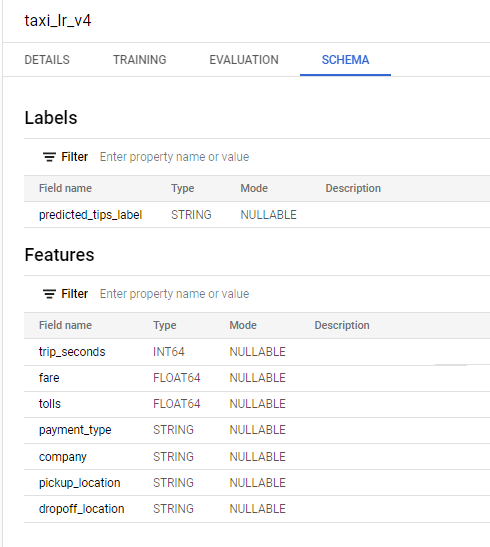


#### Evaluation:
- The query is very similar to the other training statements but introduces two more
features: pickup_location and dropoff_location. The two fields represent
the area where the taxi ride started and ended.
- After the training of the ML model, we can immediately appreciate that we've
further improved the performances of our classification model. This is clearly visible
from the **ROC AUC** value, which is **0.9834**.
-Looking at the Confusion matrix, we can choose the best threshold that gives us
the right balance between true positive and true negative predictions.
-The threshold value influences the ratio between the True Positive Rate and the
False Positive Rate. Finding the best threshold means to find a value that maximize
the True Positive Rate and minimize the False Positive Rate. <br>
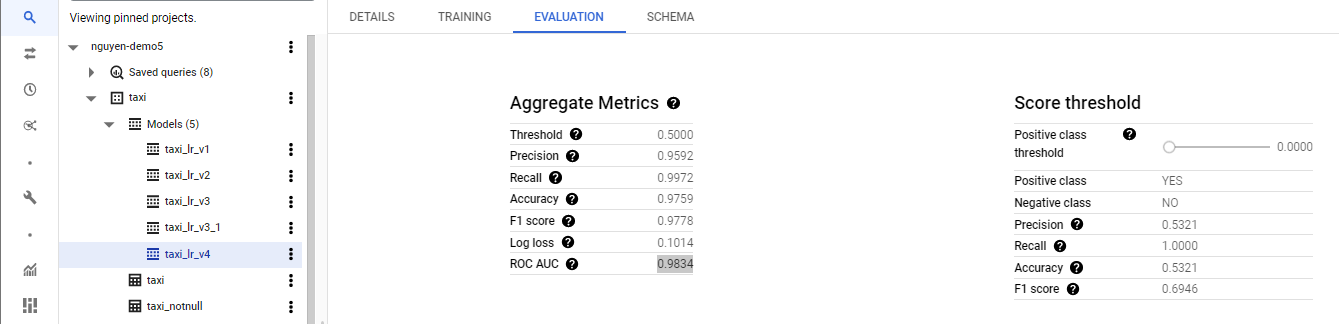

- Confusion Matrix of Version 4 Model <br>
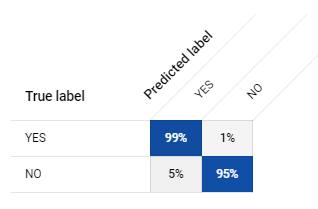

- All the other key performance indicators, such as the precision, recall, and accuracy,
are very high and close to the maximum of 1.
- From a graphical perspective, we can appreciate the excellent quality of our ML
model. In fact, the blue area under the ROC curve is very close to 1 and covers
almost the entire area of the square. The following screenshot shows the ROC curve
of the last ML model and shows that our ML model has achieved an excellent result: <br>
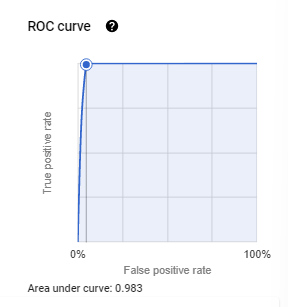

## Evaluate Model

### Review the model evaluation statistics on the Test/Train splits:
- To proceed with the evaluation stage, we choose to
pick up the model version 4, which showed the best
performance.

In [35]:
query = f"""
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr_v4`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TRAIN'))
UNION ALL
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr_v4`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TEST'))
"""
bigquery.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.963014,0.997052,0.977683,0.979738,0.097169,0.984019
1,TRAIN,0.958290,0.997135,0.975851,0.977327,0.100822,0.983915


### Review the confusion matrix for each split:
#### Training Dataset

In [36]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{DATANAME}.{DATANAME}_lr_v4`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TRAIN')
  )
"""
bigquery.query(query = query).to_dataframe()

,expected_label,NO,YES
0,NO,2511107,124913
1,YES,8245,2869860


#### Validate Dataset

In [37]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{DATANAME}.{DATANAME}_lr_v4`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'VALIDATE')
  )
"""
bigquery.query(query = query).to_dataframe()

,expected_label,NO,YES
0,NO,310102,15735
1,YES,1021,369508


#### Test Dataset

In [38]:
query = f"""
SELECT *
FROM ML.CONFUSION_MATRIX (MODEL `{DATANAME}.{DATANAME}_lr_v4`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  )
"""
bigquery.query(query = query).to_dataframe()

,expected_label,NO,YES
0,NO,326006,15418
1,YES,1187,401447


---
## Predictions: 

- In this section, we'll use the ML model to predict the probability of getting a tip from
our customers.
- To test our BigQuery ML model, we'll use the ML.PREDICT function
- Create a pandas dataframe with predictions for the test data in the table

In [39]:
query = f"""
SELECT *
FROM ML.PREDICT (MODEL `{DATANAME}.{DATANAME}_lr_v4`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  )
"""
pred = bigquery.query(query = query).to_dataframe()

- Review columns from the predictions - note that the query added columns with prefix predicted_

In [40]:
pred.columns

Index(['predicted_tips_label', 'predicted_tips_label_probs', 'unique_key',
       'taxi_id', 'trip_start_timestamp', 'trip_end_timestamp', 'trip_seconds',
       'trip_miles', 'pickup_census_tract', 'dropoff_census_tract',
       'pickup_community_area', 'dropoff_community_area', 'fare', 'tips',
       'tolls', 'extras', 'trip_total', 'payment_type', 'company',
       'pickup_latitude', 'pickup_longitude', 'pickup_location',
       'dropoff_latitude', 'dropoff_longitude', 'dropoff_location', 'splits',
       'tips_label'],
      dtype='object')

- Print the first few rows for the columns related to the actual and predicted values:

In [43]:
pred[[VAR_TARGET, f'predicted_{VAR_TARGET}', f'predicted_{VAR_TARGET}_probs', 'splits']].head(5)

,tips_label,predicted_tips_label,predicted_tips_label_probs,splits
0,YES,YES,"[{'label': 'YES', 'prob': 0.8462701776308345},...",TEST
1,NO,NO,"[{'label': 'YES', 'prob': 0.002659826493136411...",TEST
2,NO,NO,"[{'label': 'YES', 'prob': 0.002657345869196015...",TEST
3,NO,YES,"[{'label': 'YES', 'prob': 0.834140135058037}, ...",TEST
4,NO,NO,"[{'label': 'YES', 'prob': 0.002675841376392346...",TEST


- Notice the nested dictionary for predicted probabilities. In BigQuery this is a Record type structure with nested fields for label and prop. This is returned to the pandas dataframe as a nested dictionary.
- The following code sorts the dictionary for the first record by prob

In [44]:
exec('temp = pred.predicted_'+VAR_TARGET+'_probs[0]')
[sorted(x, key = lambda x: x['label']) for x in [temp]]

[[{'label': 'NO', 'prob': 0.15372982236916555},
  {'label': 'YES', 'prob': 0.8462701776308345}]]

---
## Explanations

In [47]:
query = f"""
SELECT *
FROM ML.EXPLAIN_PREDICT (MODEL `{DATANAME}.{DATANAME}_lr_v4`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST'), STRUCT(10 as top_k_features)
  )
"""
explain = bigquery.query(query = query).to_dataframe()

In [48]:
explain.head()

,predicted_tips_label,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,unique_key,taxi_id,trip_start_timestamp,trip_end_timestamp,...,payment_type,company,pickup_latitude,pickup_longitude,pickup_location,dropoff_latitude,dropoff_longitude,dropoff_location,splits,tips_label
0,NO,0.997342,"[{'feature': 'payment_type', 'attribution': -4...",-0.122307,-5.927424,0.0,19ce3432d7835774ff313f7f6a49835075d71c8f,b'\xd3\xb7\xda\xeb\xde\xbc\xe3f\xf8\xf5\xde{\x...,2019-10-12 02:00:00+00:00,2019-10-12 02:15:00+00:00,...,Cash,Flash Cab,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559063,POINT (-87.7215590627 41.968069),TEST,NO
1,NO,0.997754,"[{'feature': 'payment_type', 'attribution': -4...",-0.122307,-6.096381,0.0,69b47195649de2971e864a2afdf0e7234bef18b2,b'wG9\xf1\xdf\\m\xadZ\xdb\xdf6\xd9\xbf\x1b\xd3...,2019-10-31 04:00:00+00:00,2019-10-31 06:15:00+00:00,...,Cash,Patriot Taxi Dba Peace Taxi Associat,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559063,POINT (-87.7215590627 41.968069),TEST,NO
2,YES,0.846835,"[{'feature': 'payment_type', 'attribution': 3....",-0.122307,1.709993,0.0,1f1d722fdae87c4b606f9c403c8d93fa3a4f0ded,b'\xe1\xe6\xbb\xeb\xdd\xfb\xdb~\xdd\xdb~5\xe3\...,2019-10-05 18:30:00+00:00,2019-10-05 18:45:00+00:00,...,Credit Card,Sun Taxi,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559063,POINT (-87.7215590627 41.968069),TEST,YES
3,NO,0.997363,"[{'feature': 'payment_type', 'attribution': -4...",-0.122307,-5.935380,0.0,7b17c6c8b802a113fcd623c690fae18c0eede4e4,b'\xd1\xcd\x1b\xd7\xc7u\xef\x9f_\xf5\xee\xdds\...,2019-10-27 16:00:00+00:00,2019-10-27 16:00:00+00:00,...,Cash,Taxi Affiliation Services,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559063,POINT (-87.7215590627 41.968069),TEST,NO
4,NO,0.997068,"[{'feature': 'payment_type', 'attribution': -4...",-0.122307,-5.829264,0.0,a5385b547bd9c71b3317f4e6a98e2e6850e3cde6,b'\xe9\xa7y\xf3NZ\xefn\xde\xe5\xa6\xb6\xed\xdd...,2019-10-13 03:00:00+00:00,2019-10-13 05:30:00+00:00,...,Cash,Chicago Carriage Cab Corp,41.968069,-87.721559,POINT (-87.7215590627 41.968069),41.968069,-87.721559063,POINT (-87.7215590627 41.968069),TEST,NO


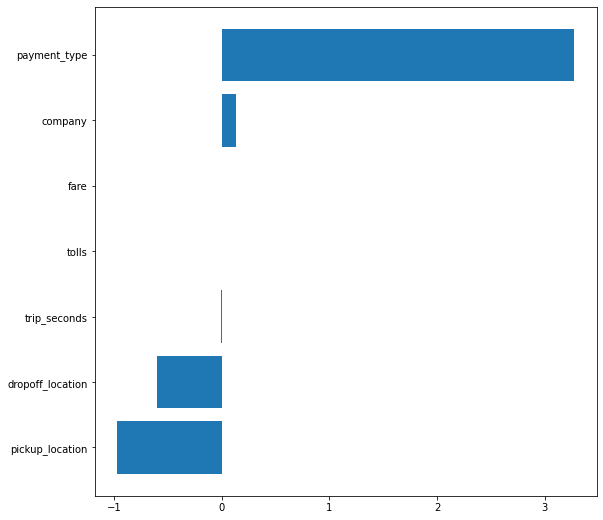

In [50]:
import matplotlib.pyplot as plt
features = []
scores = []
for k in explain.iloc[2]['top_feature_attributions']:
    features.append(k['feature'])
    scores.append(k['attribution'])
features = [x for _, x in sorted(zip(scores, features))]
scores = sorted(scores)
fig, ax = plt.subplots()
fig.set_size_inches(9, 9)
ax.barh(features, scores)
fig.show()

---
## Draw business conclusions
- In this section, we'll use our ML model, and we'll understand how many times the
BigQuery ML model is able to predict the actual outcome.
- let's see how many times the ML model is able to
correctly identify when a driver will get a tip:

In [55]:
query = f"""
SELECT COUNT (*)
FROM (
SELECT predicted_tips_label, predicted_tips_label_probs, tips_label
FROM ML.PREDICT (MODEL `{DATANAME}.{DATANAME}_lr_v4`,(
    SELECT *
    FROM `{DATANAME}.{DATANAME}_prepped`
    WHERE splits = 'TEST')
  ))
WHERE predicted_tips_label = tips_label
"""
pred = bigquery.query(query = query).to_dataframe()

In [56]:
pred

,f0_
0,727453


In [58]:
query = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE (MODEL `{DATANAME}.{DATANAME}_lr_v4`,
    (SELECT * FROM `{DATANAME}.{DATANAME}_prepped` WHERE SPLITS='TEST'))
"""
bigquery.query(query = query).to_dataframe()

,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.963014,0.997052,0.977683,0.979738,0.097169,0.98401


- To calculate this value, we've introduced the WHERE clause, filtering only the rows where
the predicted value is equal to the actual one.

- SELECT COUNT returns a value of **727,453** predictions corresponding with the predicted
value being equal to the actual one.
- On a total of **744,058** rows, we can say that our model with a standard threshold of 0.5
predicts the right outcome in **97.7683%** of cases.
- Since we've created a very effective binary logistic regression model leveraging BigQuery
ML, we're now confident with providing insights and suggestions to our taxi drivers.
- Knowing in advance the probability of getting a tip, they can behave differently according
to the probability of getting a tip from the customer they're serving.

---
## Recap
- In this notebook, we implemented a binary logistic regression model. We introduced the
business scenario based on the data collected by the city of Chicago about taxi services.
After that, we learned how the binary logistic regression technique can be used to predict
binary values.
- In order to build an effective model, we performed a detailed analysis of the data, and then
segmented the dataset according to our needs into three set of datas: data for training, data for evaluation and testing data to apply our classification model
- During the training phase of the BigQuery ML model, we constantly improved the
performances of the ML model based on the confusion matrix and the ROC AUC value.
- After that, we evaluated the best ML model on a new set of records to verify the absence
of overfitting and gain more confidence in the good quality of our binary logistic
regression model.
- Finally, we applied our ML model to the last subset of records to predict the probability of
getting a tip or not from the customer at the end of each taxi ride. We discovered that our
ML model is able to correctly predict the customer's behavior in almost 98% of cases